In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf


/Users/yashshah/opt/anaconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
stock_symbol = 'MRF.NS'

In [5]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [6]:
type(data)


pandas.core.frame.DataFrame

In [7]:

data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-11,56450.0,56900.000000,54725.000000,55345.601562,54956.507812,14323
2019-02-12,55750.0,56178.000000,54900.000000,55355.398438,54966.234375,10994
2019-02-14,55600.0,56600.000000,55315.000000,56302.199219,55906.378906,8943
2019-02-15,56302.0,56408.300781,55000.000000,55136.851562,54752.148438,12188
2019-02-18,55248.0,55499.000000,54254.199219,54460.148438,54080.164062,5980


In [8]:

len(data)

1235

In [9]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-05,142885.0,143974.343750,140411.296875,141645.750000,141645.750000,19822
2024-02-06,142245.0,143600.000000,141761.093750,143387.703125,143387.703125,8245
2024-02-07,144385.0,144827.546875,142532.000000,142996.796875,142996.796875,7534
2024-02-08,143850.0,143850.000000,142010.046875,142483.093750,142483.093750,7121
2024-02-09,143750.0,143750.000000,136300.000000,137083.343750,137083.343750,26612


In [10]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

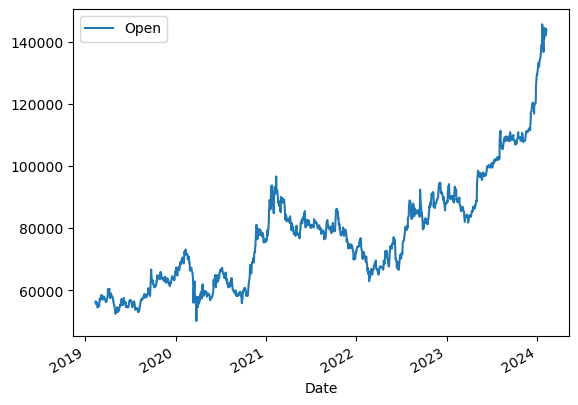

In [11]:
opn.plot()


In [12]:
#cls = data[['Close']]
#cls.plot()


In [13]:
import matplotlib.pyplot as plt

In [14]:
ds = opn.values

In [15]:
ds

array([[ 56450.],
       [ 55750.],
       [ 55600.],
       ...,
       [144385.],
       [143850.],
       [143750.]])

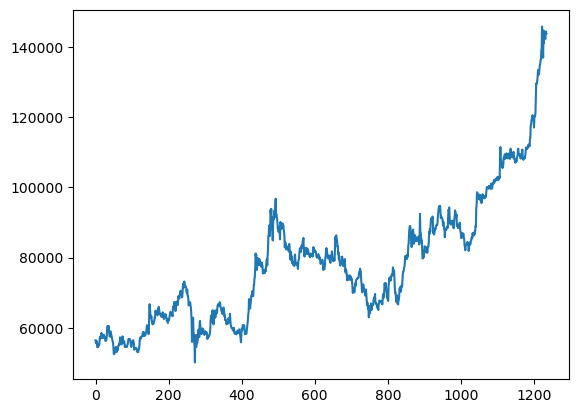

In [16]:
plt.plot(ds)

In [17]:
import numpy as np

In [18]:
from sklearn.preprocessing import MinMaxScaler
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [19]:
len(ds_scaled), len(ds)

(1235, 1235)

In [20]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size


In [21]:
train_size,test_size

(864, 371)

In [22]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]


In [23]:
len(ds_train),len(ds_test)

(864, 371)

In [24]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [25]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [26]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [27]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [28]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

In [ ]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
type(train_predict)

In [ ]:
test = np.vstack((train_predict,test_predict))

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [ ]:
len(ds_test)

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [ ]:
len(ds_scaled)

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()
len(ds_new)


In [ ]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()